<a href="https://colab.research.google.com/github/woodwj/TD_mlproject/blob/Model_1/TDML_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 - Investigations

In [1]:
%pip install yfinance # collect packages

Note: you may need to restart the kernel to use updated packages.


**Model 1 - Normal Equations; predicting stock closing prices from opening prices**

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error

class dataset:

    def fetch(self, stock, period):
        d = yf.download(stock, period=period, progress=False)
        return d["Open"].to_numpy().reshape(d.shape[0],1), d["Close"].to_numpy().reshape(d.shape[0],1)

    def tilda(self,data):
        return np.concatenate([np.ones((data.shape[0],1)), data],axis=1)

    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    def __init__(self,stocks,period):
        self.X,self.Y = self.fetch(stocks, period)
        split = int(len(self.X)*0.8)
        X_tr = self.X[:split]
        X_te = self.X[split:]
        self.Y_tr = self.Y[:split]
        self.Y_te = self.Y[split:]
        self.X_te = self.tilda(X_te)
        self.X_tr = self.tilda(X_tr)
        #self.X_val = self.tilda(X)
        #self.Y_val = Y

class model:
    def __init__(self, dataset):
        self.data = dataset

    def f(self,X_t):
        return  X_t @ self.W

    def error(self):
        return self.data.Y_te - self.f(self.data.X_te)

    def RMSE(self):
        return np.sqrt(np.mean((self.error())**2))

    def MAPE(self):
      return mean_absolute_percentage_error(self.data.Y_te,self.f(self.data.X_te))

class pen_inv_model(model):

    def __init__(self, dataset):
        super().__init__(dataset)

    def train(self):
        self.W = np.linalg.pinv(self.data.X_tr) @ self.data.Y_tr


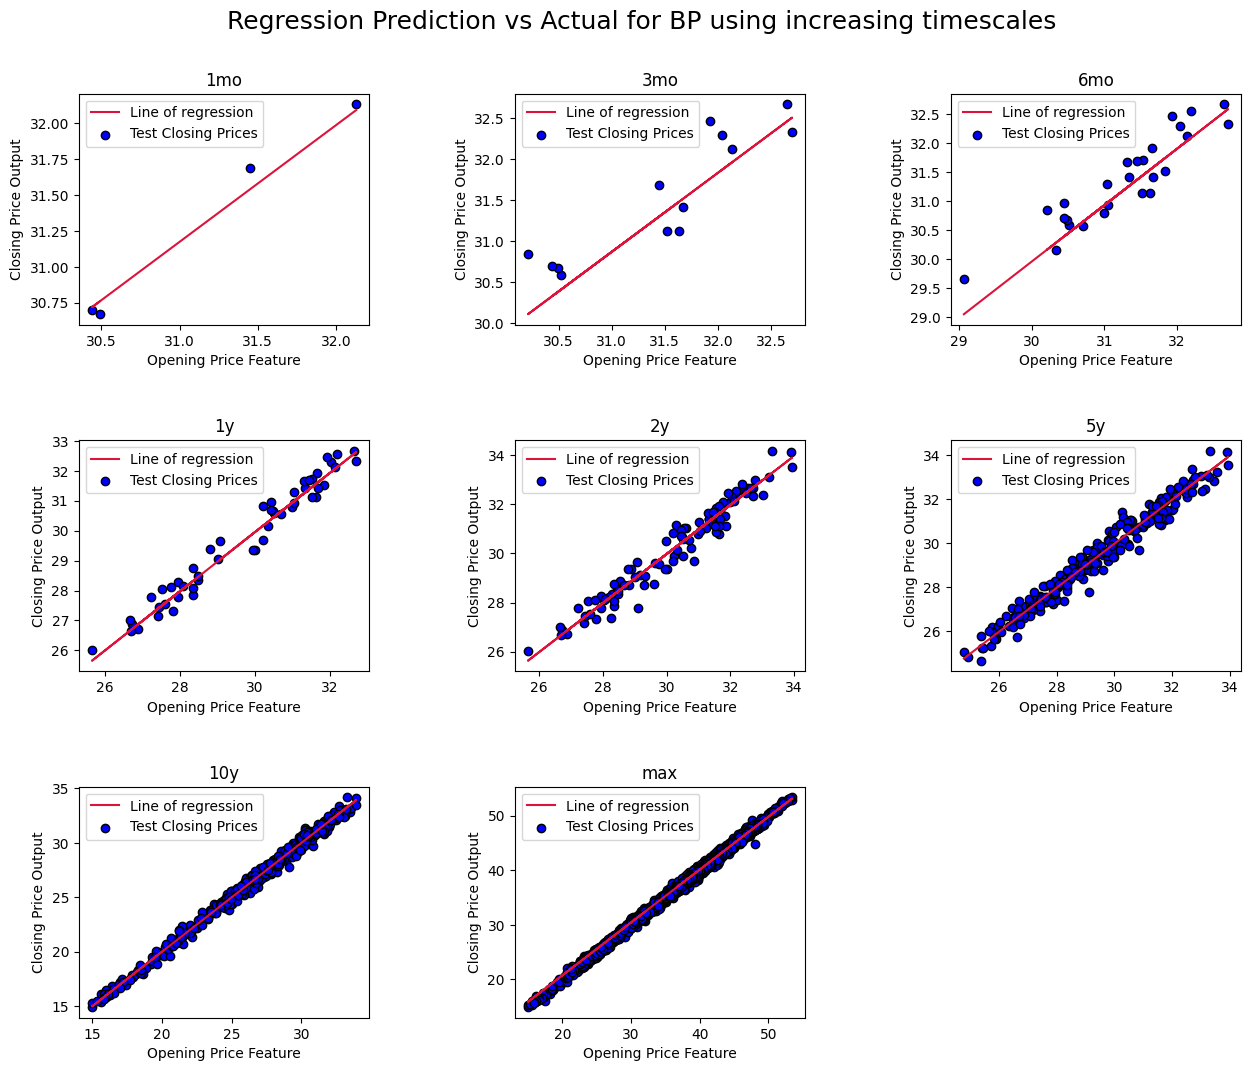

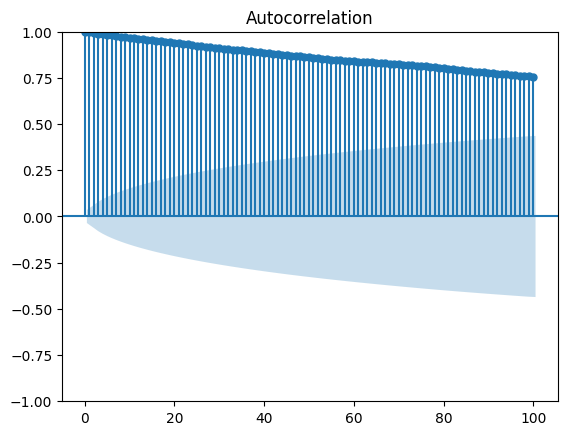

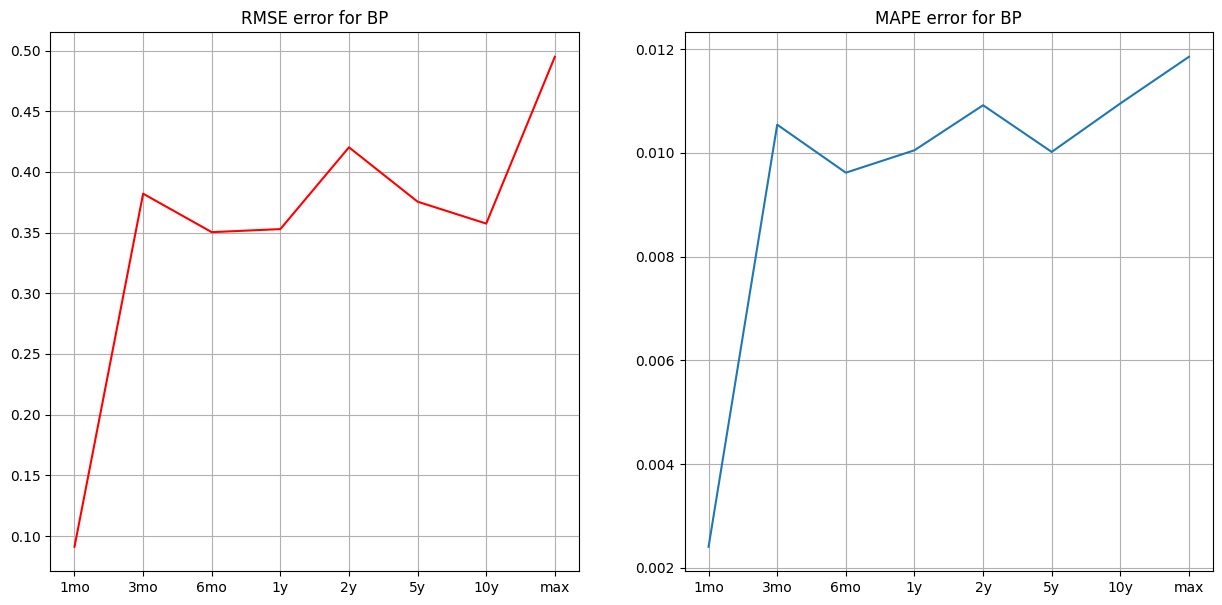

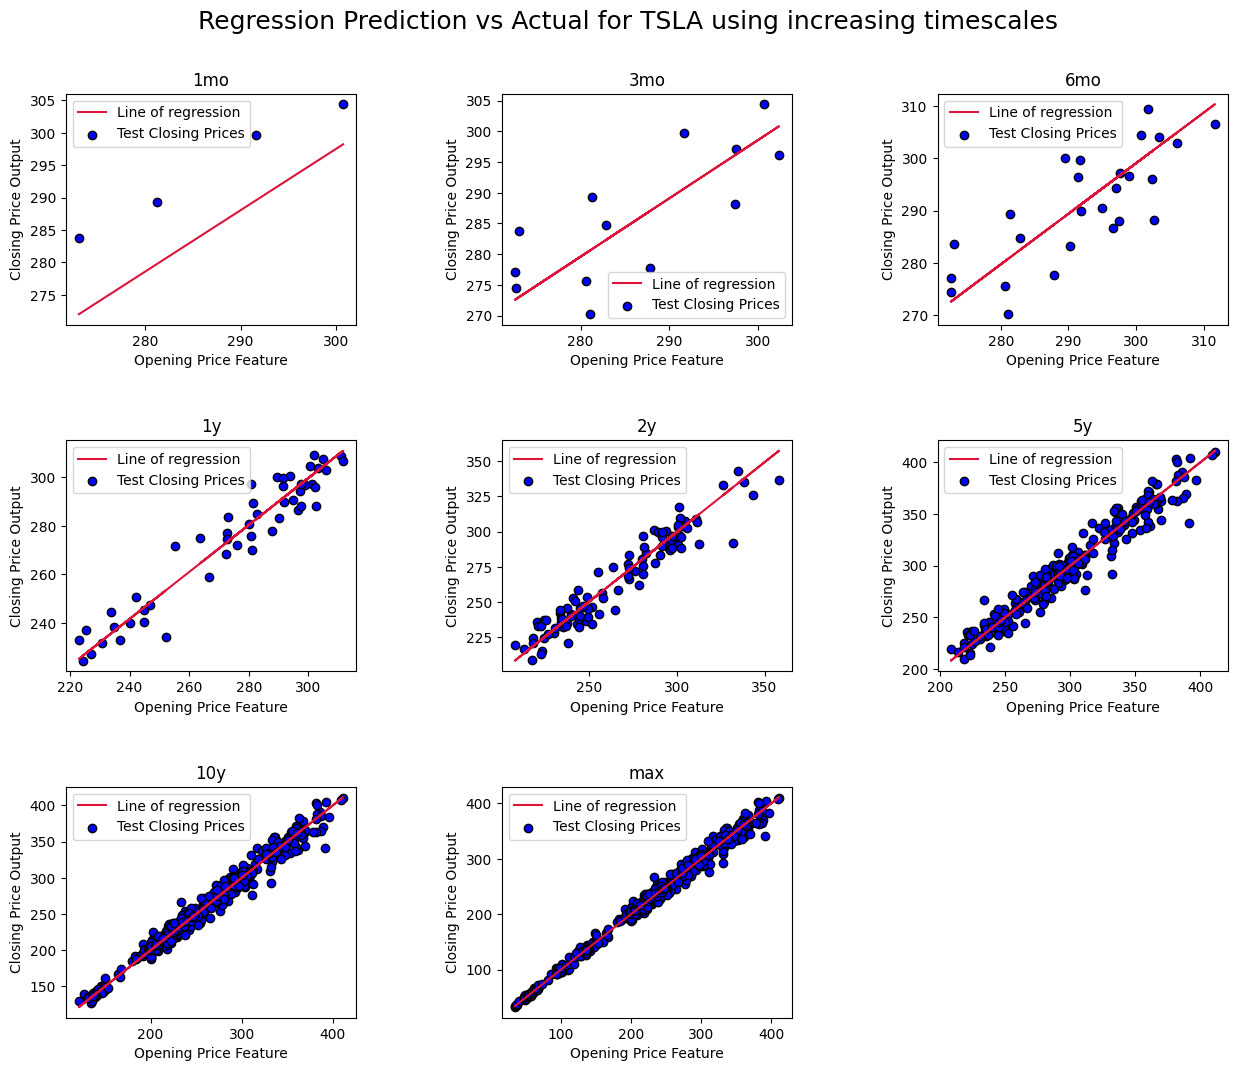

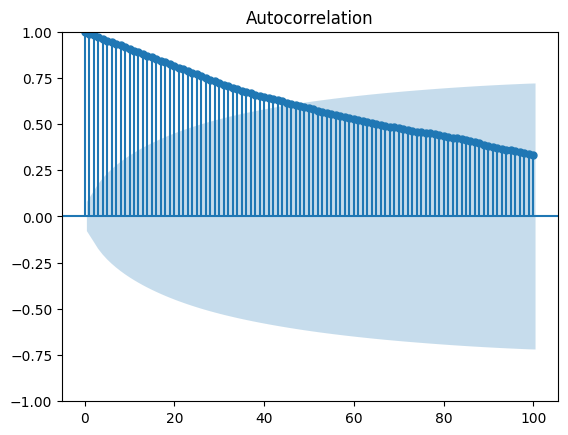

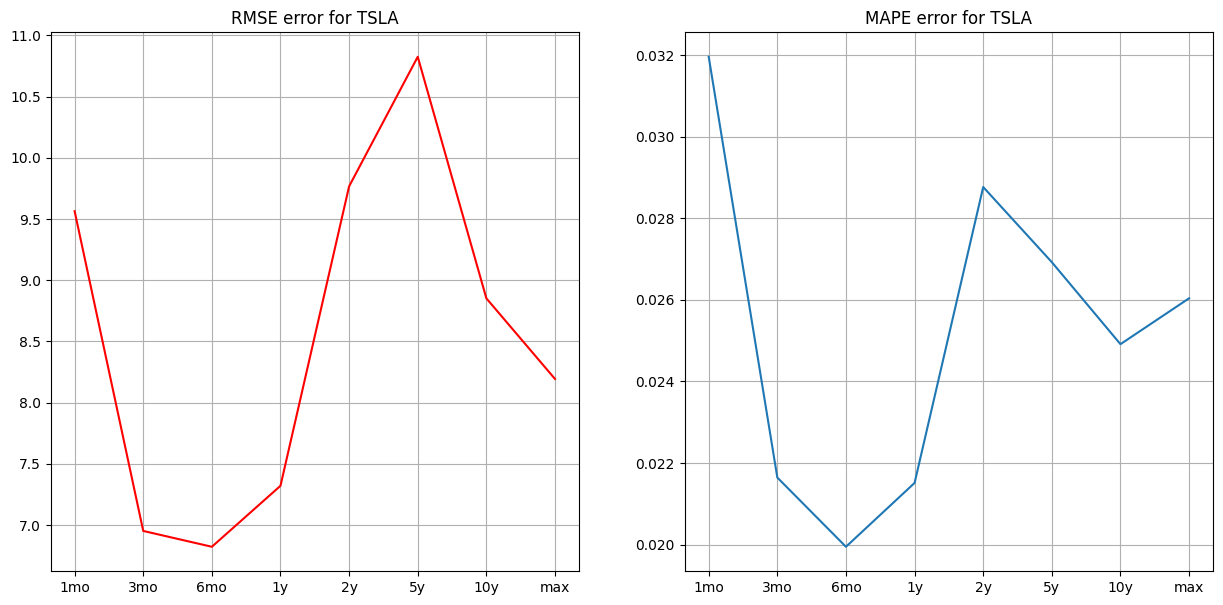

In [3]:
def experiment(stocks, periods):

  for stock in stocks.split():
    RMSE_scores = {}
    MAPE_scores = {}

    # set number of columns (use 3 to demonstrate the change)
    ncols = 3
    # calculate number of rows
    nrows = len(periods) // ncols + (len(periods) % ncols > 0)

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle(f"Regression Prediction vs Actual for {stock} using increasing timescales", fontsize=18, y=0.95)
    for n, period in enumerate(periods):
      d = dataset(stock,period)
      model = pen_inv_model(d)
      model.train()
      y_prediction = model.f(d.X_te)

      RMSE_scores[period] = model.RMSE()
      MAPE_scores[period] = model.MAPE()

      # add a new subplot iteratively using nrows and cols
      ax = plt.subplot(nrows, ncols, n + 1)
      # plot predicted against input with actual
      pred, = ax.plot(d.X_te[:,1:], y_prediction, c='crimson')
      pred.set_label('Line of regression')
      actu = ax.scatter(d.X_te[:,1:], d.Y_te, c ='blue', edgecolors='black')
      actu.set_label('Test Closing Prices')
      ax.legend()
      ax.set_title(period)
      ax.set_xlabel('Opening Price Feature')
      ax.set_ylabel('Closing Price Output')
    
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.show()

    # d is max period dataset
    plot_acf(d.X_te[:,1:], lags=100)
    plt.figure(figsize=(15, 7))

    plt.subplot(1,2,1)
    plt.plot(list(RMSE_scores.keys()),list(RMSE_scores.values()),'r-')
    plt.grid()
    plt.title(f"RMSE error for {stock}")
    plt.subplot(1,2,2)
    plt.plot(list(MAPE_scores.keys()),list(MAPE_scores.values()))
    plt.grid()
    plt.title(f"MAPE error for {stock}")
    plt.show()

# valid periods: 5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
periods = ("1mo","3mo","6mo","1y","2y","5y","10y","max")
experiment("BP TSLA",periods)

Depending on the stock, the timescale we consider can introduce error as underlying patterns shift. Demonstrated by BP and Tesla stock autocorelation, MAPE and RMSE error metrics on given timescales. We'll need to consider this a hyperparemeter to tune for a given stock based off it's volatility. This is important as we are scoping into underlying stock pricing patterns with which our model must fit to give accurate predictions for the near future. In this case the final 20% of the timescale.

Further to this we ought to control how much emphasis we place on said extracted patterns, after all what we are predicting is non-linear and we wish to minimize error within this simple model. Next will add l2 regularization (λ hyperameter) to control underfitting/overfitting. Then use a gridsearch to tune these hyperparameters before evaluating the effectiveness of this model.

**Model 2 - L2 Regularization training**

In [4]:
class l2_rls_model(model):

    def __init__(self,dataset):
        super().__init__(dataset)

    def train(self, lmbda):
        """
        lmbda:  positive hyperparameter controls how much regularisation our
                model performs. Allowing us to adjust under or overfitting by 
                using greater or fewer of weights. Tuning this hyperparameter
                allows us to decide how much emphasis is place on what weve seen so far.

        Returns:    weights that minimises the gradient of our error/objective function.
                    Using penrose inv if l = 0 or the L2 Regularised Least Squares.

                    We use the numpy penrose inverse of our data
                    And if there are infantly many solutions then w has minimum norm.
        """
        X, y = self.data.X_tr, self.data.Y_tr
        
        # Compute the coefficient vector.
        # if lambda is 0 then use pseudo-inverse.
        if lmbda == 0. :
            # libray penrose inverse function (for unified N>d,N<d)
            self.W = np.linalg.pinv(X) @ y

        else:# use the Regularized Least Squares Method 
            d = X.shape[1] # d number of features.
            I = np.identity(d) # d as X tildaed (w_0).
            self.W = ( np.linalg.inv((X.T @ X) + (np.dot(lmbda, I))) ) @ (X.T @ y)
        # w = (x_t @ X + l.I)^-1 @ X_t @ Y
        # Return w; trained model parameters.

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import time

def CV_timeseries_gridwalk(stock, parameters, metric = "MAPE"):

  results = {}

  stats = {'params' : list(product(*[parameters[k] for k in parameters])),
                'fold_0_scores' : [],
                'fold_1_scores' : [],
                'fold_2_scores' : [],
                'fold_3_scores' : [],
                'fold_4_scores' : [],
                'mean_scores' : [],
                'scores_std' : []}

  for param in stats['params']:
    d = dataset(stock, param[0])
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

    fold = 0
    for train, test in tscv.split(d.X):
      param_scores = []

      X_val,Y_val = d.X_te, d.Y_te
      d.X_te, d.X_tr, d.Y_te, d.Y_tr = d.tilda(d.X[test]), d.tilda(d.X[train]), d.Y[test], d.Y[train]
      m = l2_rls_model(d)
      
      m.train(param[1])
      
      # append score to the respective parameter-fold records
      if metric == "MAPE": err = m.MAPE()
      if metric == "RMSE": err = m.RMSE()
      if metric == "ABS": err = m.error()
      err = m.error()
      param_scores.append(err)
      stats[f'fold_{fold}_scores'].append(err)
      fold += 1
    
    stats['mean_scores'].append(round(np.array(param_scores).mean(),3))
    stats['scores_std'].append(round(np.array(param_scores).std(),3))

  return stats


# valid periods: 5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
periods = ['1mo','3mo','6mo','1y','2y','5y','10y','max']
resultsBP = CV_timeseries_gridwalk("BP", parameters = {'periods': periods, 'L':range(0,100000,1000)}, metric='MAPE')
resultsTSLA = CV_timeseries_gridwalk("TSLA", parameters = {'periods': periods, 'L':range(0,100000,1000)}, metric='MAPE')


In [ ]:
print("BP")
for c, params in enumerate(resultsBP['params']):
  if resultsBP['mean_scores'][c] < 0.01 and resultsBP['mean_scores'][c] > -0.01:
    print(params, resultsBP['mean_scores'][c])
 
print("\nTSLA")
for c, params in enumerate(resultsTSLA['params']):
  if resultsTSLA['mean_scores'][c] < 0.01 and resultsTSLA['mean_scores'][c] > -0.01:
    print(params, resultsTSLA['mean_scores'][c])

BP
('10y', 0) 0.001
('10y', 1000) -0.004
('10y', 2000) 0.004
('max', 20000) -0.007
('max', 21000) -0.002
('max', 22000) 0.003
('max', 23000) 0.008

TSLA
('5y', 67000) -0.005


After gridsearching with large hyperameter step values we can focus in with another more focused gridsearch.

In [7]:
print("BP 10y l 0-2000")
resultsBP = CV_timeseries_gridwalk(["BP"], parameters = {'periods': ['10y'], 'L':range(0,2000,10)}, metric='MAPE')
for c, params in enumerate(resultsBP['params']):
    if resultsBP['mean_scores'][c] < 0.001 and resultsBP['mean_scores'][c] > -0.001:
      print(params,resultsBP['mean_scores'][c],resultsBP['scores_std'][c])

print("\nBP max 21000-22000")
resultsBP = CV_timeseries_gridwalk(['BP'], parameters = {'periods': ['max'], 'L':range(21000,22000,10)},metric='MAPE')
for c, params in enumerate(resultsBP['params']):
    if resultsBP['mean_scores'][c] < 0.001 and resultsBP['mean_scores'][c] > -0.001:
      print(params,resultsBP['mean_scores'][c],resultsBP['scores_std'][c])

print("\nTSLA 5y 67000-69000")
resultsTSLA = CV_timeseries_gridwalk(['TSLA'], parameters = {'periods': ['5y'], 'L':range(67000,69000,10)},metric='MAPEs')
for c, params in enumerate(resultsTSLA['params']):
    if resultsTSLA['mean_scores'][c] < 0.001 and resultsTSLA['mean_scores'][c] > -0.001:
      print(params,resultsTSLA['mean_scores'][c],resultsTSLA['scores_std'][c])

BP 10y l 0-2000
('10y', 1420) -0.0 0.363
('10y', 1430) -0.0 0.363
('10y', 1440) -0.0 0.363
('10y', 1450) -0.0 0.363
('10y', 1460) -0.0 0.363
('10y', 1470) -0.0 0.363
('10y', 1480) 0.0 0.363
('10y', 1490) 0.0 0.363
('10y', 1500) 0.0 0.363
('10y', 1510) 0.0 0.363
('10y', 1520) 0.0 0.363
('10y', 1530) 0.0 0.363

BP max 21000-22000
('max', 21370) -0.0 0.36
('max', 21380) -0.0 0.36
('max', 21390) -0.0 0.36
('max', 21400) -0.0 0.36
('max', 21410) -0.0 0.36
('max', 21420) -0.0 0.36
('max', 21430) -0.0 0.36
('max', 21440) -0.0 0.36
('max', 21450) -0.0 0.36
('max', 21460) -0.0 0.36
('max', 21470) 0.0 0.36
('max', 21480) 0.0 0.36
('max', 21490) 0.0 0.36
('max', 21500) 0.0 0.36
('max', 21510) 0.0 0.36
('max', 21520) 0.0 0.36
('max', 21530) 0.0 0.36
('max', 21540) 0.0 0.36
('max', 21550) 0.0 0.36
('max', 21560) 0.0 0.36

TSLA 5y 67000-69000
('5y', 67180) -0.0 10.846
('5y', 67190) -0.0 10.846
('5y', 67200) -0.0 10.846
('5y', 67210) 0.0 10.846
('5y', 67220) 0.0 10.846
('5y', 67230) 0.0 10.846


### TUNED HYPERPARAMETERS

|Stock        | Period      | λ |
| ----------- | ----------- | ----------- |
| BP          | 10yr        | 1485        |
| BP          | Max         | 21415       |
| TSLA        | 5yr         | 67615       |

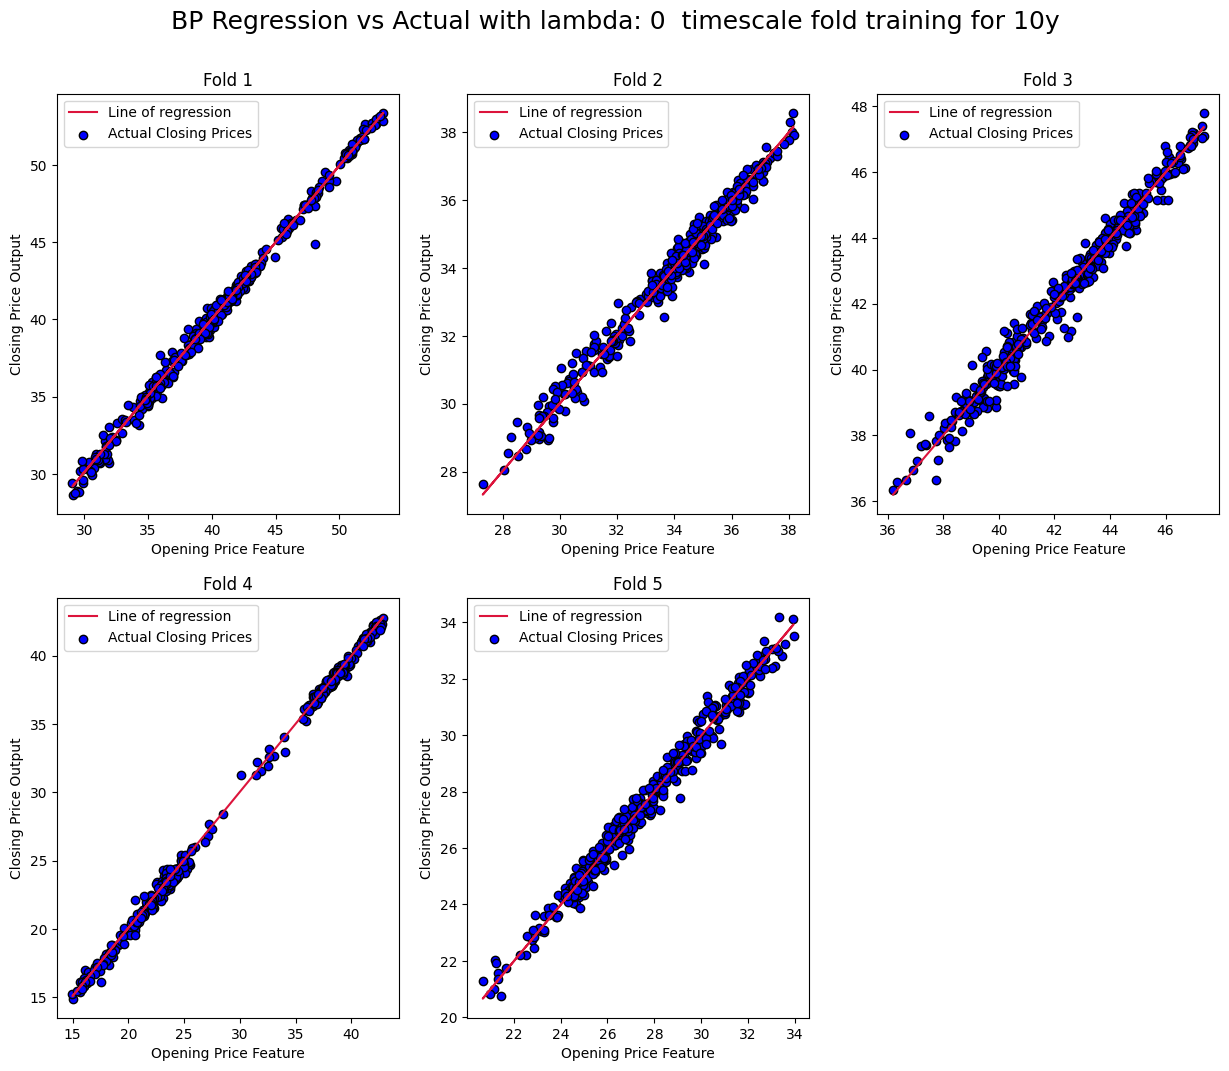

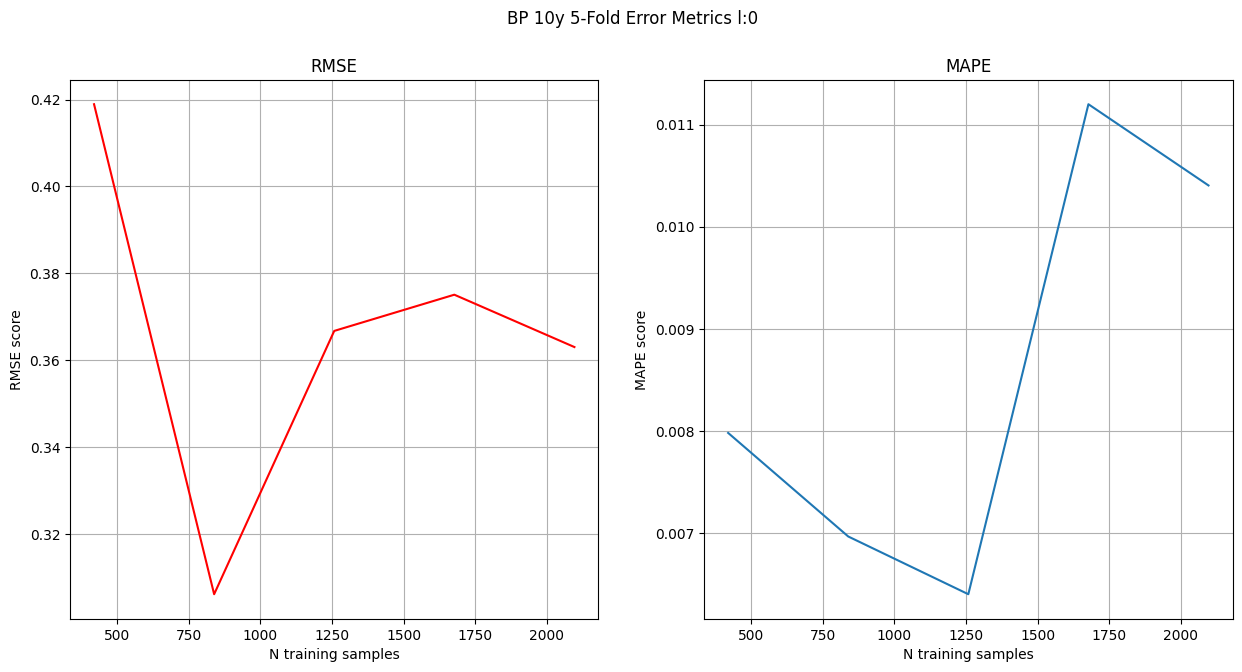

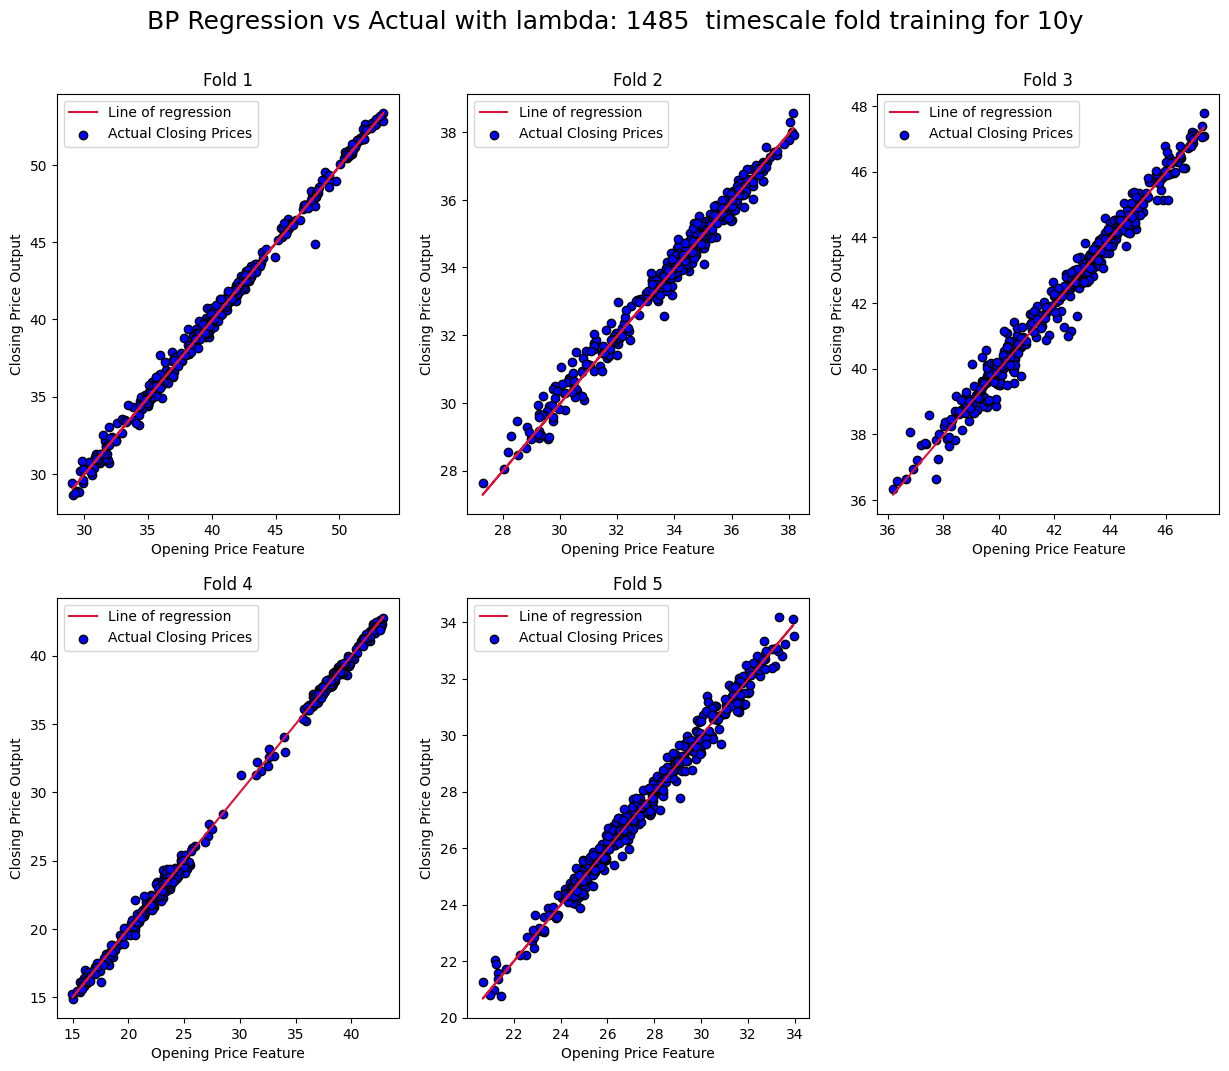

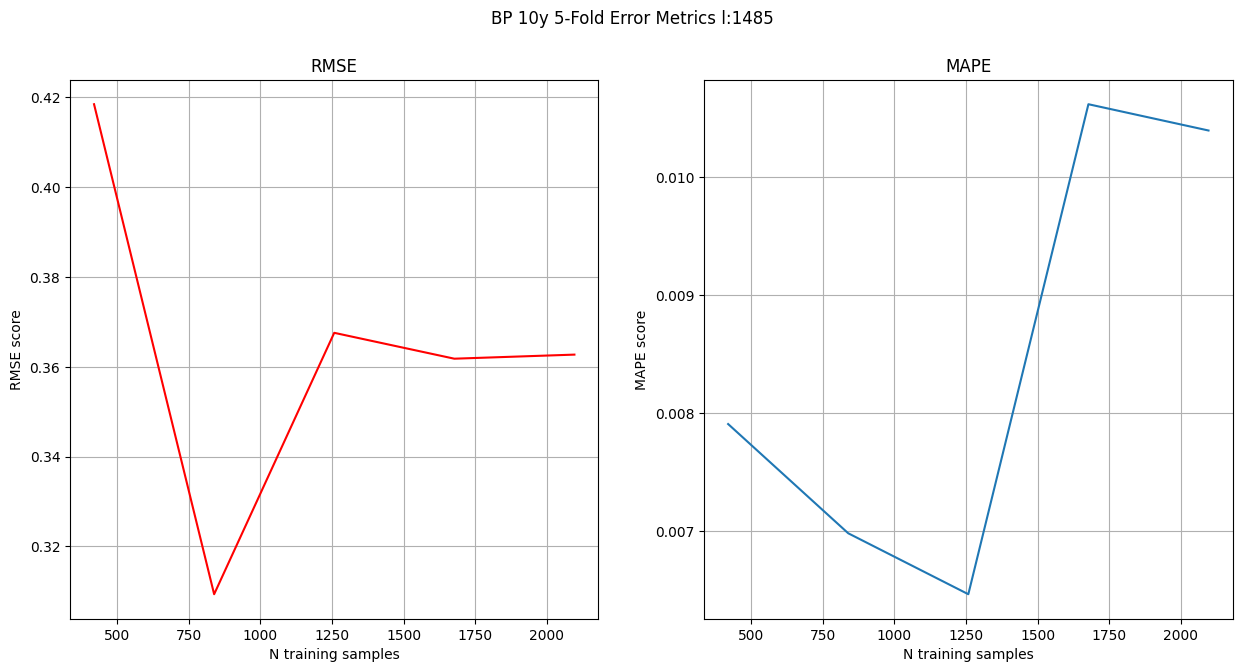

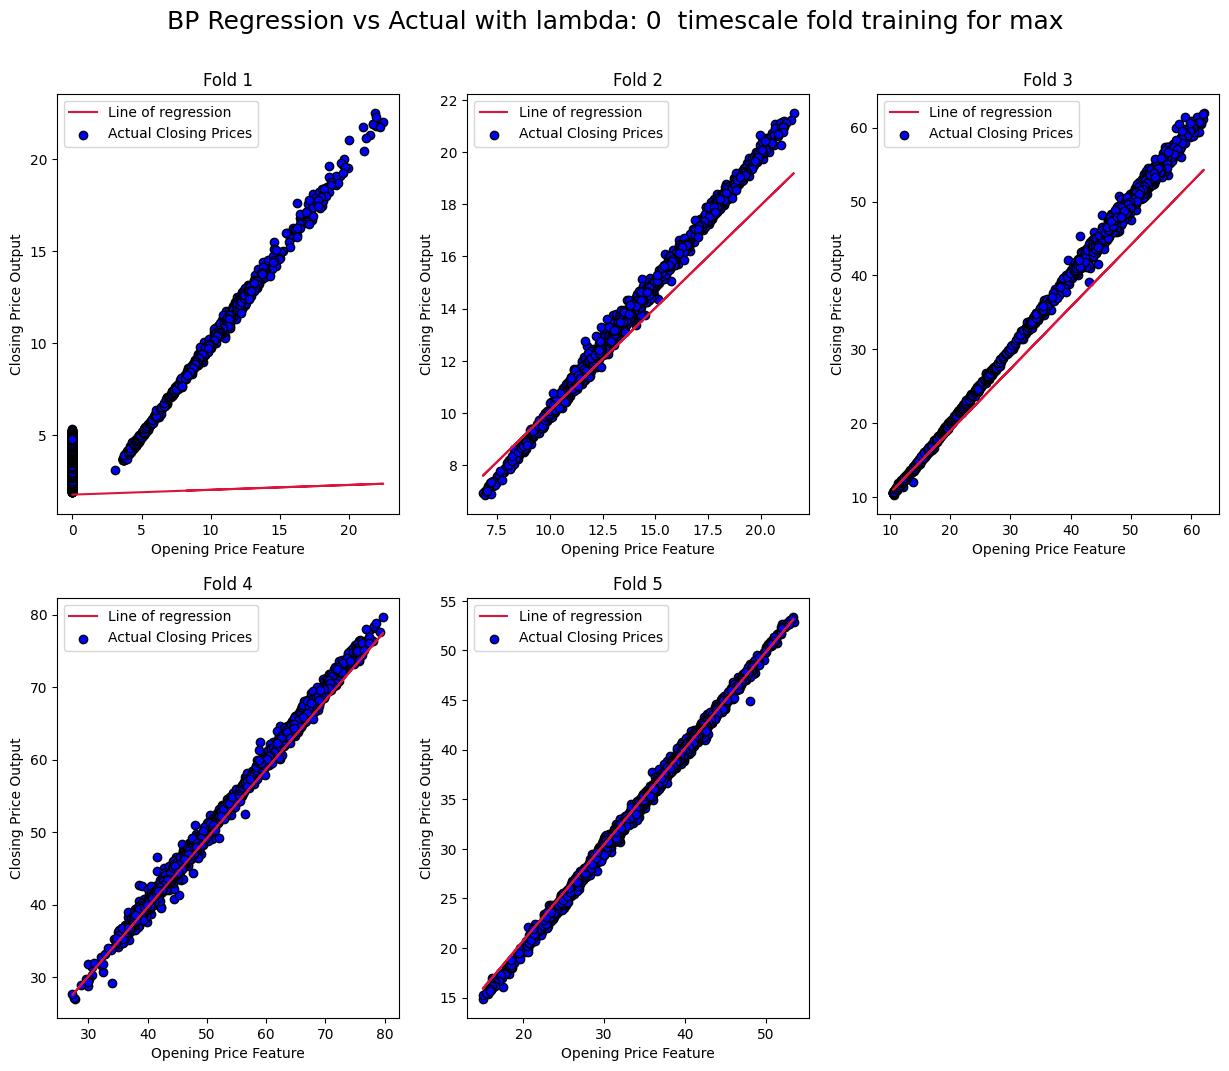

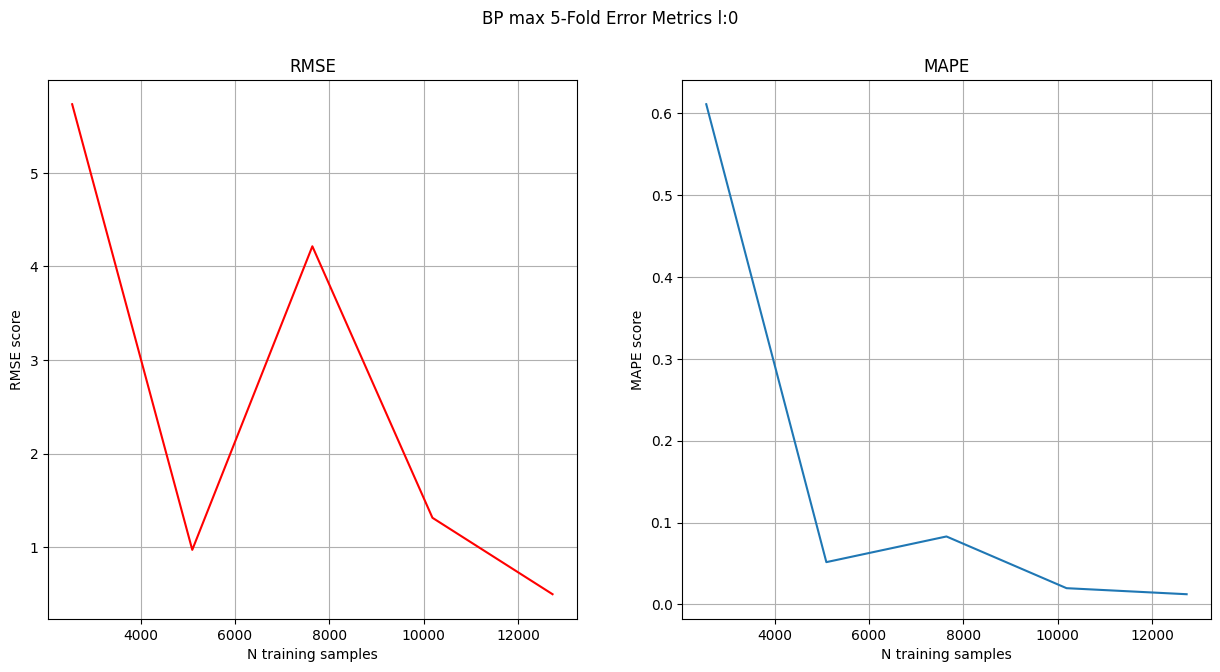

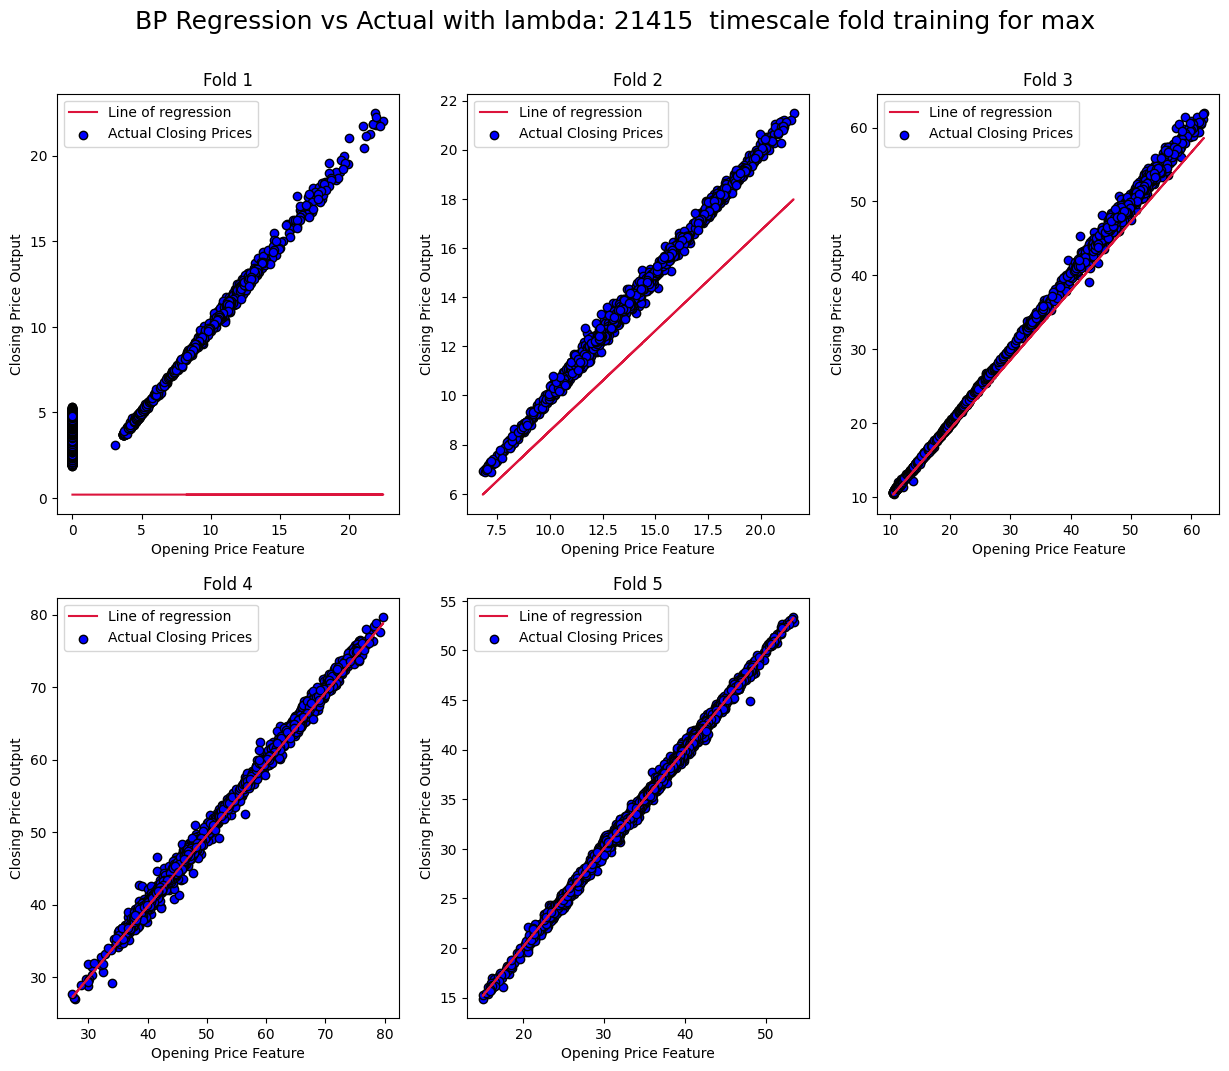

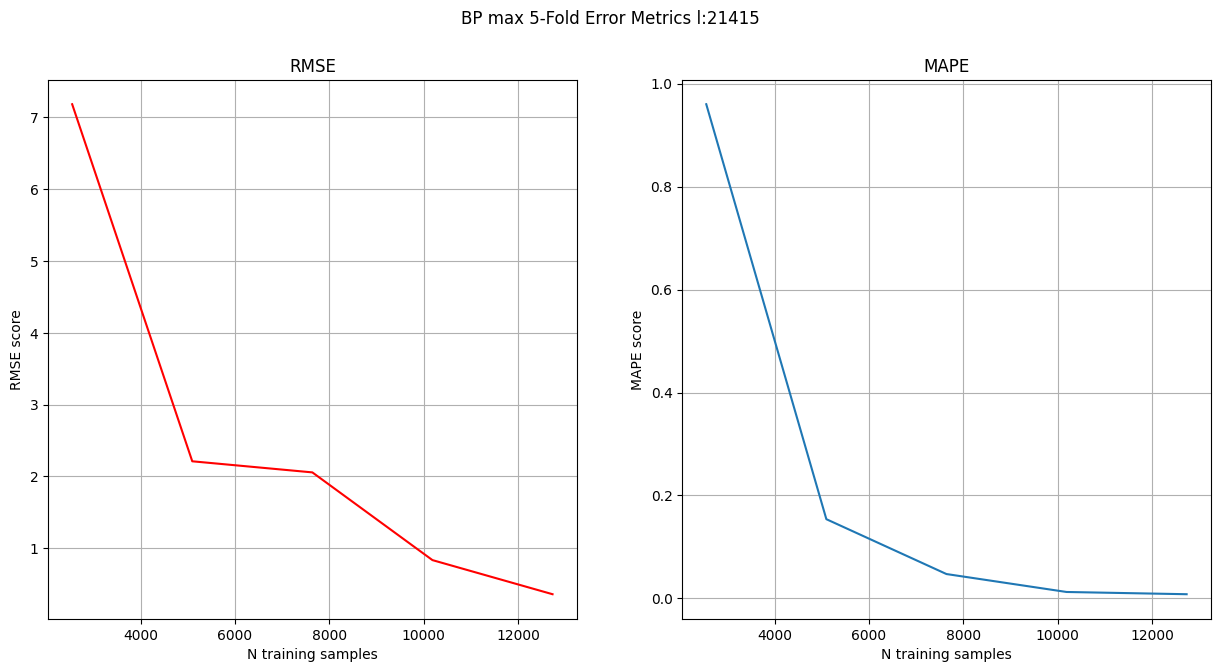

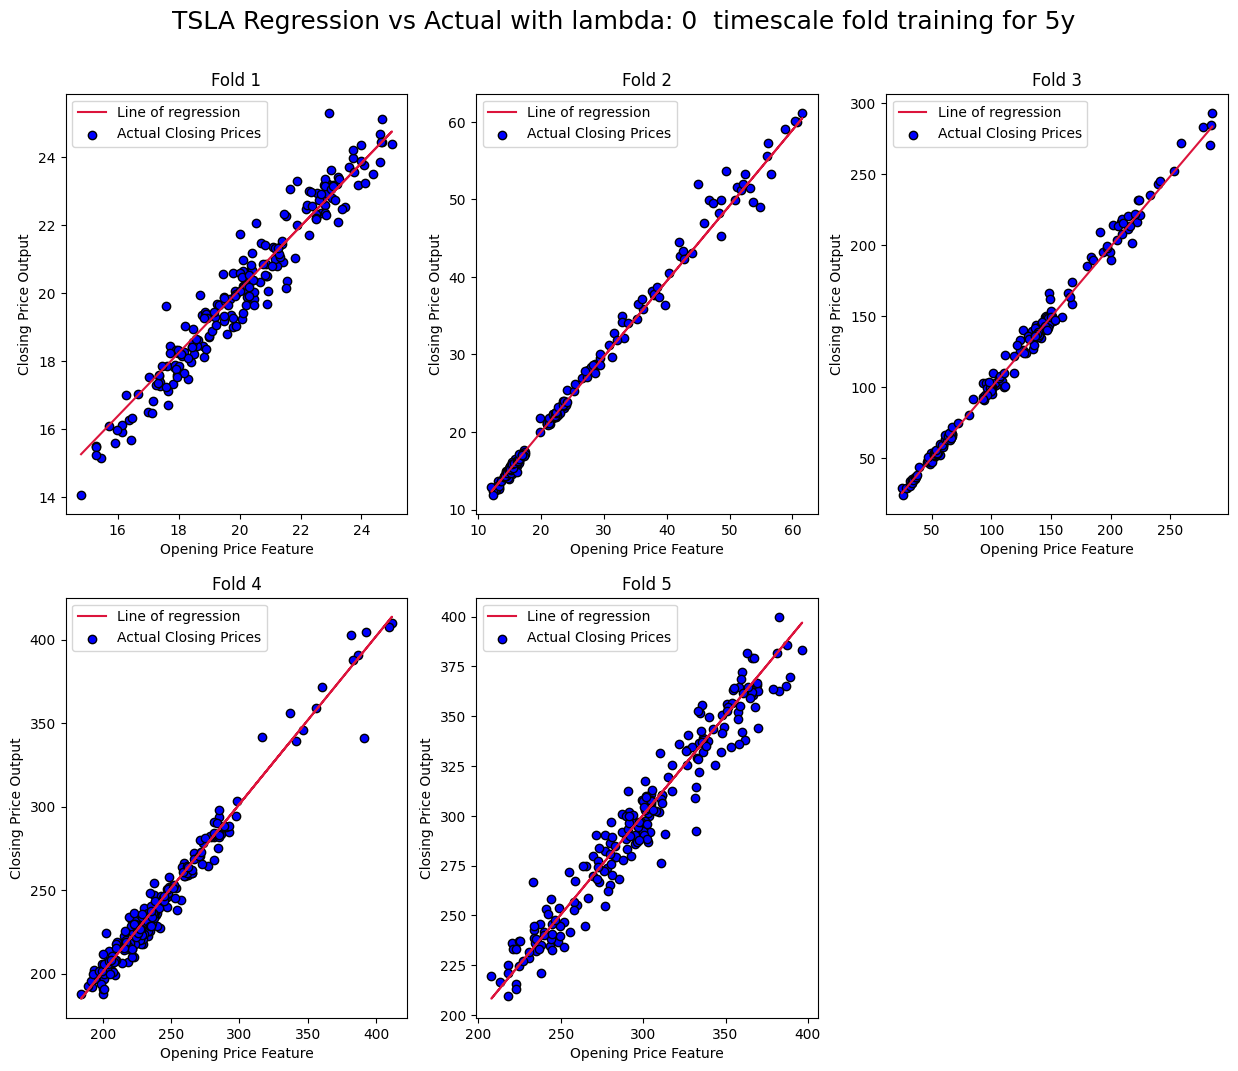

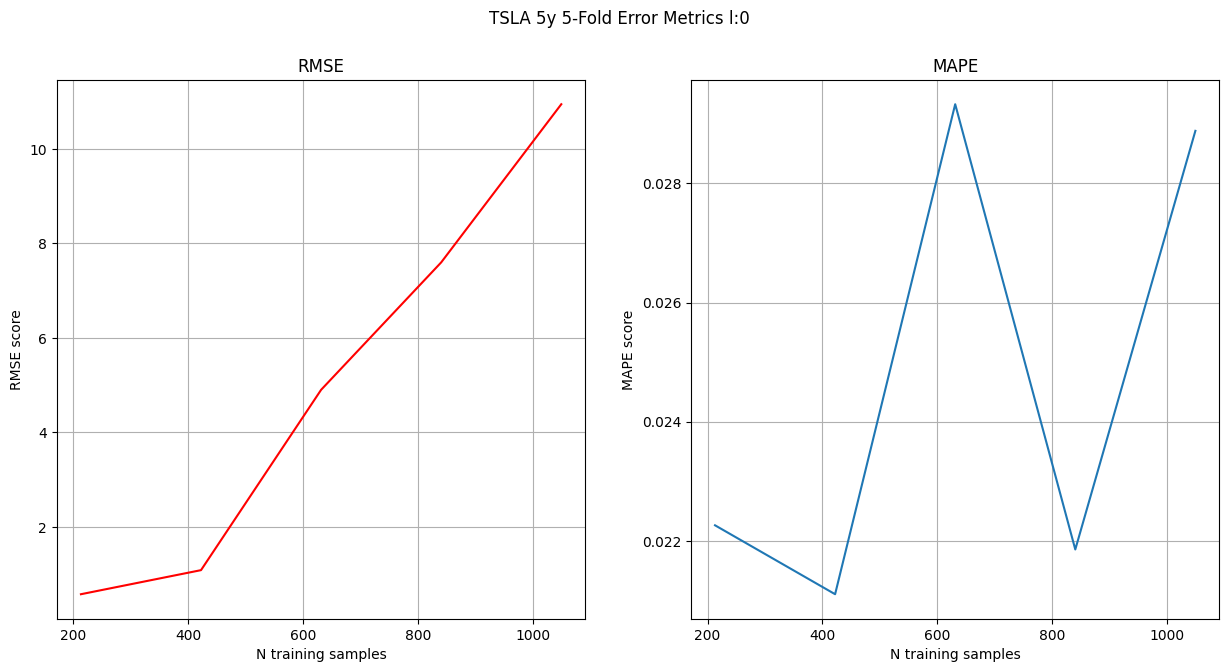

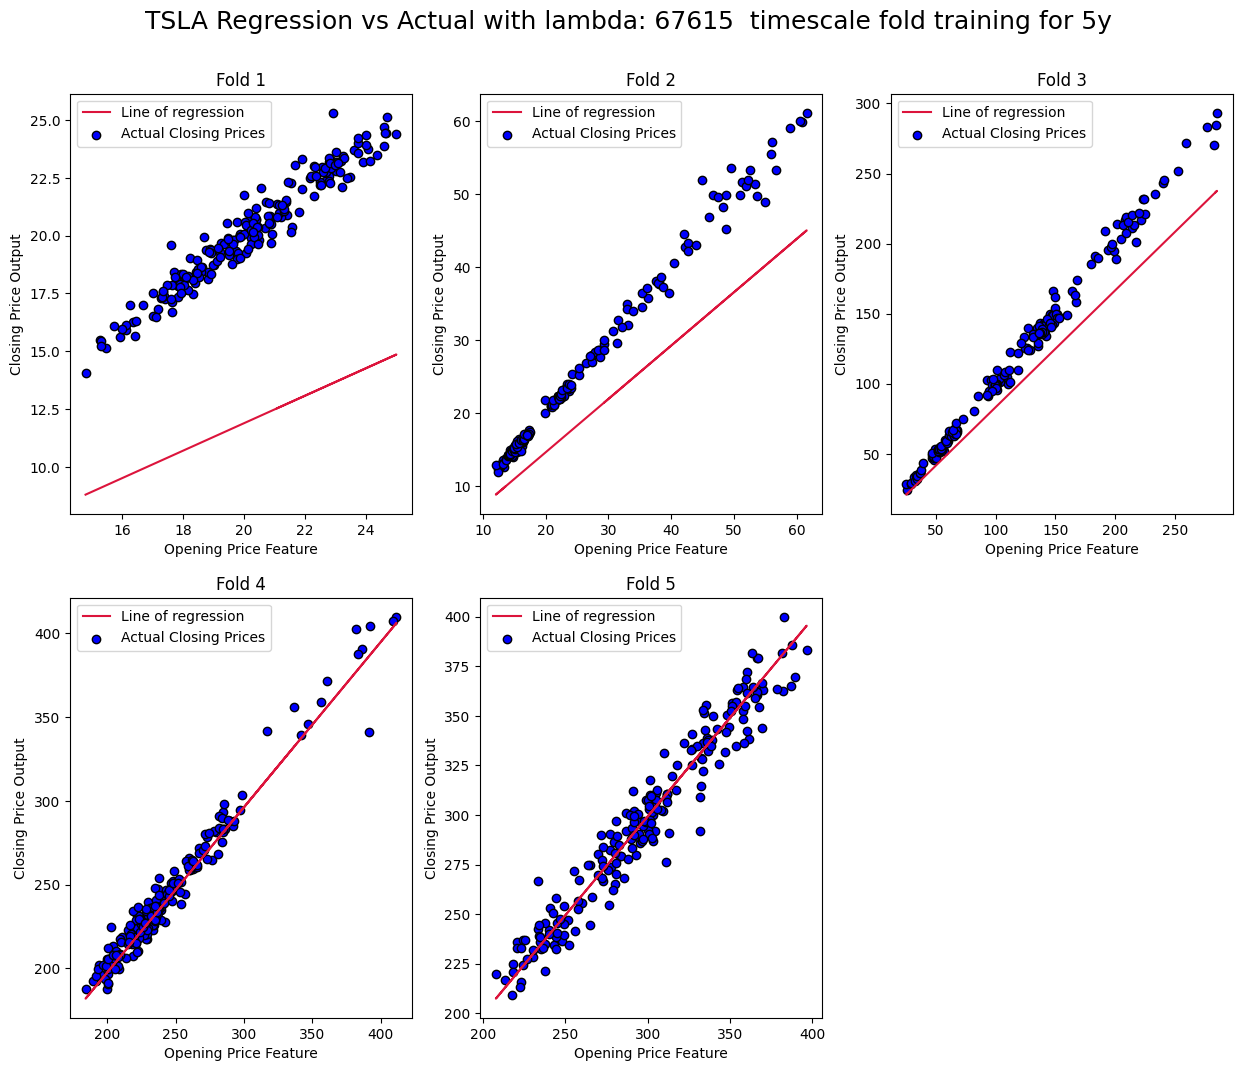

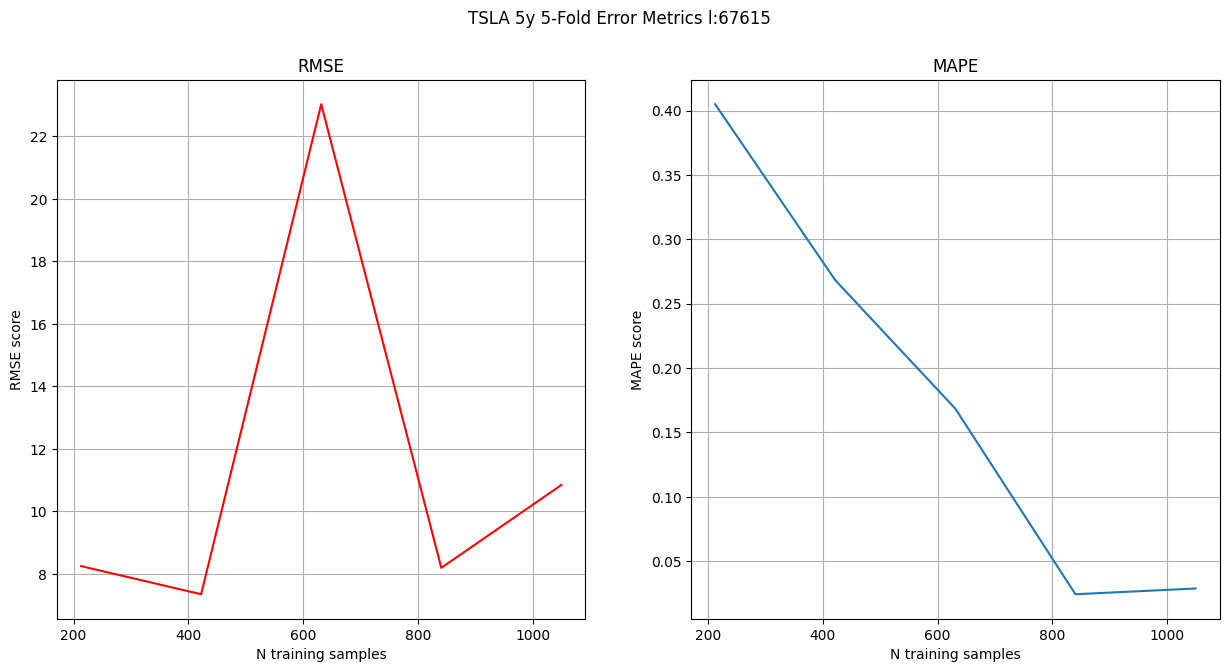

In [22]:
from sklearn.model_selection import TimeSeriesSplit

def hyperam_experiment(stock, period, l):

    d = dataset(stock,period)
    RMSE_scores = {}
    MAPE_scores = {}

    # set number of columns (use 3 to demonstrate the change)
    ncols = 3
    # calculate number of rows
    nrows = 2

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle(f"{stock} Regression vs Actual with lambda: {l}  timescale fold training for {period} ", fontsize=18, y=0.95)

    c = 1
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
    for train, test in tscv.split(d.X):
        X_val,Y_val = d.X_te, d.Y_te
        d.X_te, d.X_tr, d.Y_te, d.Y_tr = d.tilda(d.X[test]), d.tilda(d.X[train]), d.Y[test], d.Y[train]

        model = l2_rls_model(d)
        model.train(l)
        y_prediction = model.f(d.X_te)

        RMSE_scores[train.size] = model.RMSE()
        MAPE_scores[train.size] = model.MAPE()
        
        # plot predicted against input with actual
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, c)
        ax.set_title(f'Fold {c}')
        # plot predicted against input with actual
        pred, = ax.plot(d.X_te[:,1:], y_prediction, c='crimson')
        pred.set_label('Line of regression')
        actu = ax.scatter(d.X_te[:,1:], d.Y_te, c ='blue', edgecolors='black')
        actu.set_label('Actual Closing Prices')
        ax.legend()
        ax.set_xlabel('Opening Price Feature')
        ax.set_ylabel('Closing Price Output')

        c +=1
        
    plt.show()


    plt.figure(figsize=(15, 7))
    plt.suptitle(f"{stock} {period} 5-Fold Error Metrics l:{l}")
    ax = plt.subplot(1,2,1)
    RMSE, = ax.plot(list(RMSE_scores.keys()),list(RMSE_scores.values()),'r-')
    ax.grid()
    ax.set_title("RMSE")
    ax.set_xlabel('N training samples')
    ax.set_ylabel('RMSE score')
    ax = plt.subplot(1,2,2)
    MAPE, = plt.plot(list(MAPE_scores.keys()),list(MAPE_scores.values()))
    ax.grid()
    ax.set_title("MAPE")
    ax.set_xlabel('N training samples')
    ax.set_ylabel('MAPE score')
    plt.subplots_adjust(hspace=0.2)
    plt.show()


# valid periods: 5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
hyperam_experiment("BP","10y", 0)
hyperam_experiment("BP","10y", 1485)
hyperam_experiment("BP","max", 0)
hyperam_experiment("BP","max", 21415)
hyperam_experiment("TSLA","5y", 0)
hyperam_experiment("TSLA","5y", 67615)
